In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import seawater as sw
from seawater.library import T90conv
from scipy import stats

import ncar_jobqueue
from dask.distributed import Client

### Define CESM case

In [2]:
case = 'cesm22cocco.G1850ECOIAF.T62_g17.003'

### get potential density

In [3]:
path = '/glade/scratch/kristenk/archive/' + case + '/ocn/proc/tseries/month_1'
variables = ['PD']

In [4]:
%%time

ds_list = []

print(f'reading {case}')

ds_mon = xr.Dataset()

for v in variables:
    
    print(v)
    
    files = sorted(glob(f'{path}/{case}.pop.h.{v}.024901-031012.nc'))       

    dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True)

    
    ds_mon = xr.merge((ds_mon, dsv))
    ds_list.append(ds_mon)

reading cesm22cocco.G1850ECOIAF.T62_g17.003
PD
CPU times: user 72 ms, sys: 11 ms, total: 83 ms
Wall time: 339 ms


In [5]:
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
ds_mon = ds_mon.drop([v for v in ds_mon.variables if v not in keep_vars])

In [6]:
cesm_ann_ds = ds_mon.mean(dim='time')

### get Alk control and noGCB

In [7]:
case='cesm22cocco.G1850ECOIAF.T62_g17.003'
file='/glade/scratch/kristenk/archive/' + case + '/ocn/proc/mean5thIAF/mean_IAF5_ALK.nc'
ds = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['ALK'] = ds['ALK']

file='/glade/scratch/kristenk/archive/' + case + '/ocn/proc/mean5thIAF/mean_IAF5_ALK_ALT_CO2.nc'
ds = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['ALK_ALT_CO2_noGCB'] = ds['ALK_ALT_CO2']

### get Alk with 2x GCB

In [8]:
case='cesm22cocco.G1850ECOIAF.T62_g17.004'
file='/glade/scratch/kristenk/archive/' + case + '/ocn/proc/mean5thIAF/mean_IAF5_ALK_ALT_CO2.nc'
ds = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['ALK_ALT_CO2_2xGCB'] = ds['ALK_ALT_CO2']

### get Alk with 100m dissolution length scale

In [9]:
case='cesm22cocco.G1850ECOIAF.T62_g17.009'
file='/glade/scratch/kristenk/archive/' + case + '/ocn/proc/mean5thIAF/mean_IAF5_ALK_ALT_CO2.nc'
ds = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['ALK_ALT_CO2_100mDLS'] = ds['ALK_ALT_CO2']

### get Alk with 1000m dissolution length scale

In [10]:
case='cesm22cocco.G1850ECOIAF.T62_g17.010'
file='/glade/scratch/kristenk/archive/' + case + '/ocn/proc/mean5thIAF/mean_IAF5_ALK_ALT_CO2.nc'
ds = xr.open_dataset(file,decode_times=False,decode_coords=False)
cesm_ann_ds['ALK_ALT_CO2_1000mDLS'] = ds['ALK_ALT_CO2']

### get CaCO3 fluxes for the GCB region (26 to 27 sigma isopycnal outcrop region)
These files were made using these notebooks (in this directory):

SO_CaCO3_fluxes.ipynb

SO_CaCO3_fluxes_100mDLS.ipynb

SO_CaCO3_fluxes_1000mDLS.ipynb

In [11]:
file='/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.003/ocn/proc/mean5thIAF/mean_IAF5_GCB_CaCO3flux.nc'
SAZ_ds = xr.open_dataset(file,decode_times=False,decode_coords=False)

In [12]:
file='/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.009/ocn/proc/mean5thIAF/mean_IAF5_GCB_CaCO3flux.nc'
ds = xr.open_dataset(file,decode_times=False,decode_coords=False)
SAZ_ds['CaCO3_ALT_CO2_FLUX_IN_100mDLS'] = ds['CaCO3_ALT_CO2_FLUX_IN']

In [13]:
file='/glade/scratch/kristenk/archive/cesm22cocco.G1850ECOIAF.T62_g17.010/ocn/proc/mean5thIAF/mean_IAF5_GCB_CaCO3flux.nc'
ds = xr.open_dataset(file,decode_times=False,decode_coords=False)
SAZ_ds['CaCO3_ALT_CO2_FLUX_IN_1000mDLS'] = ds['CaCO3_ALT_CO2_FLUX_IN']

In [14]:
SAZ_ds

<xarray.Dataset>
Dimensions:                         (nlat: 384, nlon: 320, z_t: 60)
Coordinates:
  * z_t                             (z_t) float32 500.0 1500.0 ... 537500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    TLONG                           (nlat, nlon) float64 ...
    TLAT                            (nlat, nlon) float64 ...
    CaCO3_FLUX_IN                   (z_t, nlat, nlon) float32 ...
    CaCO3_ALT_CO2_FLUX_IN_100mDLS   (z_t, nlat, nlon) float32 ...
    CaCO3_ALT_CO2_FLUX_IN_1000mDLS  (z_t, nlat, nlon) float32 ...

### compute sigma densities

In [15]:
cesm_ann_ds['sigma'] = cesm_ann_ds.PD * 1000. - 1000.

### Now DS has everything we need

In [16]:
cesm_ann_ds

<xarray.Dataset>
Dimensions:               (nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
    TLAT                  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                 (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t                   (z_t) float32 500.0 1500.0 ... 512502.8 537500.0
  * z_t_150m              (z_t_150m) float32 500.0 1500.0 ... 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    dz                    (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TAREA                 (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    REGION_MASK           (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    PD                    (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>
    ALK                   (z_t, nlat, nlon) float32 ...
    ALK_ALT_CO2_noGCB     (z_t, nlat, nlon) float32 ...
    ALK_ALT_CO2_2xGCB     (z_t, nlat, nlon) float32 ...
    ALK_ALT_CO2_100mDLS   (z_t, nlat, nlon) float32 ...
    ALK_ALT_CO2_1000mDLS  (z_t, nlat, nlon) float32 ...
    sigma                 (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>

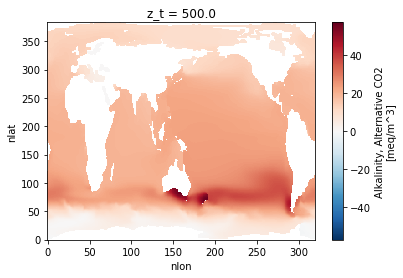

In [17]:
diff = cesm_ann_ds.ALK_ALT_CO2_100mDLS.isel(z_t=0) - cesm_ann_ds.ALK.isel(z_t=0)
diff.plot()

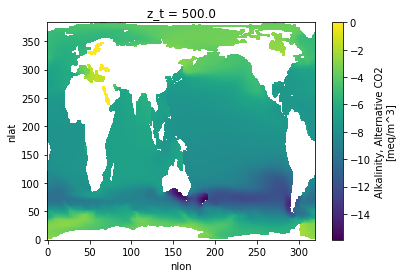

In [18]:
diff = cesm_ann_ds.ALK_ALT_CO2_1000mDLS.isel(z_t=0) - cesm_ann_ds.ALK.isel(z_t=0)
diff.plot()

In [19]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_woa['z_t'] = cesm_ann_ds.z_t

In [20]:
lons=ds_woa.TLONG
lats=ds_woa.TLAT
area=ds_woa.TAREA
area_m=ds_woa.TAREA * 1e-4
depths_m=ds_woa.z_t * 0.01
dz=cesm_ann_ds.dz
dz_m=cesm_ann_ds.dz * 0.01

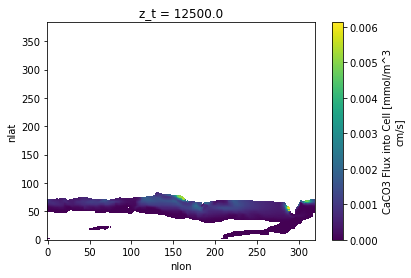

In [21]:
SAZ_ds.CaCO3_FLUX_IN.isel(z_t=12).plot()

### Calculate Ocean Volume

In [22]:
volume = area_m * dz_m

In [23]:
volume = volume.where(cesm_ann_ds.sigma>0.) #so we just get ocean volume

In [24]:
volume_tot = volume.sum(dim=['z_t','nlat','nlon'])

In [25]:
%%time
volume_tot = volume_tot * 1.e-9 #convert from m3 to km3
volume_tot = volume_tot.values #should be ~1.35e9
volume_tot

CPU times: user 2min, sys: 1min 9s, total: 3min 10s
Wall time: 3min 10s


array(1.3251214e+09)

#### upper/deep volumes

In [27]:
%%time
#get volume of "upper ocean"
volume_upper = volume.where(cesm_ann_ds.sigma<=27.4)
volume_upper_tot = volume_upper.sum(dim=['z_t','nlat','nlon'])
volume_upper_tot = volume_upper_tot * 1.e-9 #convert from m3 to km3
volume_upper_tot = volume_upper_tot.values
volume_upper_tot

CPU times: user 1min 55s, sys: 60 s, total: 2min 55s
Wall time: 2min 55s


array(2.88890642e+08)

In [28]:
#get volume of "deep ocean"
volume_deep = volume.where(cesm_ann_ds.sigma>27.4)
volume_deep_tot = volume_deep.sum(dim=['z_t','nlat','nlon'])
volume_deep_tot = volume_deep_tot * 1.e-9 #convert from m3 to km3
volume_deep_tot = volume_deep_tot.values
volume_deep_tot

array(1.03623076e+09)

#### N/S of 45°S

In [29]:
#get volume ocean north of 45S
volume_N45 = volume.where(cesm_ann_ds.sigma>0.).where(lats>-45.)
volume_N45_tot = volume_N45.sum(dim=['z_t','nlat','nlon'])
volume_N45_tot = volume_N45_tot * 1.e-9 #convert from m3 to km3
volume_N45_tot = volume_N45_tot.values
volume_N45_tot

array(1.09805211e+09)

In [30]:
#get volume of ocean south of 45S
volume_S45 = volume.where(cesm_ann_ds.sigma>0.).where(lats<=-45.)
volume_S45_tot = volume_S45.sum(dim=['z_t','nlat','nlon'])
volume_S45_tot = volume_S45_tot * 1.e-9 #convert from m3 to km3
volume_S45_tot = volume_S45_tot.values
volume_S45_tot

array(2.27069288e+08)

In [22]:
# ### skip running the above cells because they take forever
# volume_tot = 1.3251214e+09
# volume_upper_tot = 2.88890642e+08
# volume_deep_tot = 1.03623076e+09
# volume_N45_tot = 1.09805211e+09
# volume_S45_tot = 2.27069288e+08

## Now do alk in upper and lower pools

### Calculate ALK for deep waters for noGCB experiment

In [23]:
%%time
glb_ALK_noGCB_bottom = cesm_ann_ds.ALK_ALT_CO2_noGCB.where(cesm_ann_ds.sigma>27.4)
#dims: z_t,nlat,nlon
glb_ALK_noGCB_bottom = esmlab.weighted_sum(glb_ALK_noGCB_bottom, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
glb_ALK_noGCB_bottom = esmlab.weighted_sum(glb_ALK_noGCB_bottom, weights=dz_m, dim=['z_t']).compute()
#dims: none

CPU times: user 1min 56s, sys: 57.9 s, total: 2min 54s
Wall time: 2min 55s


In [24]:
glb_ALK_noGCB_bottom = glb_ALK_noGCB_bottom.values * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
glb_ALK_noGCB_bottom

2521.7612880294996

In [25]:
#divide by volume to get mean concentration
mean_glb_ALK_noGCB_bottom = glb_ALK_noGCB_bottom/volume_deep_tot  * 1.e9
mean_glb_ALK_noGCB_bottom

2433.5904562700875

### Calculate ALK  for upper waters for noGCB experiment

In [26]:
%%time
glb_ALK_noGCB_top = cesm_ann_ds.ALK_ALT_CO2_noGCB.where(cesm_ann_ds.sigma<=27.4)
#dims: z_t,nlat,nlon
glb_ALK_noGCB_top = esmlab.weighted_sum(glb_ALK_noGCB_top, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
glb_ALK_noGCB_top = esmlab.weighted_sum(glb_ALK_noGCB_top, weights=dz_m, dim=['z_t']).compute()
#dims: none

CPU times: user 1min 50s, sys: 45.6 s, total: 2min 36s
Wall time: 2min 36s


In [27]:
glb_ALK_noGCB_top = glb_ALK_noGCB_top.values * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
glb_ALK_noGCB_top

690.0990787014848

In [28]:
#divide by volume to get mean concentration
mean_glb_ALK_noGCB_top = glb_ALK_noGCB_top/volume_upper_tot  * 1.e9
mean_glb_ALK_noGCB_top

2388.790006917167

### Calculate ALK for deep waters for 2xGCB experiment

In [47]:
%%time
glb_ALK_2xGCB_bottom = cesm_ann_ds.ALK_ALT_CO2_2xGCB.where(cesm_ann_ds.sigma>27.4)
#dims: z_t,nlat,nlon
glb_ALK_2xGCB_bottom = esmlab.weighted_sum(glb_ALK_2xGCB_bottom, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
glb_ALK_2xGCB_bottom = esmlab.weighted_sum(glb_ALK_2xGCB_bottom, weights=dz_m, dim=['z_t']).compute()
#dims: none

In [50]:
glb_ALK_2xGCB_bottom = glb_ALK_2xGCB_bottom.values * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
glb_ALK_2xGCB_bottom

2527.8404029531607

In [51]:
#divide by volume to get mean concentration
mean_glb_ALK_2xGCB_bottom = glb_ALK_2xGCB_bottom/volume_deep_tot  * 1.e9
mean_glb_ALK_2xGCB_bottom

2439.457030844112

### Calculate ALK  for upper waters for 2xGCB experiment

In [52]:
%%time
glb_ALK_2xGCB_top = cesm_ann_ds.ALK_ALT_CO2_2xGCB.where(cesm_ann_ds.sigma<=27.4)
#dims: z_t,nlat,nlon
glb_ALK_2xGCB_top = esmlab.weighted_sum(glb_ALK_2xGCB_top, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
glb_ALK_2xGCB_top = esmlab.weighted_sum(glb_ALK_2xGCB_top, weights=dz_m, dim=['z_t']).compute()
#dims: none

In [55]:
glb_ALK_2xGCB_top = glb_ALK_2xGCB_top.values  * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
glb_ALK_2xGCB_top

678.1447669561335

In [56]:
#divide by volume to get mean concentration
mean_glb_ALK_2xGCB_top = glb_ALK_2xGCB_top/volume_upper_tot  * 1.e9
mean_glb_ALK_2xGCB_top

2347.409947885175

### Calculate Alk for bottom waters for 100mDLS experiment

In [57]:
%%time
glb_ALK_100mDLS_bottom = cesm_ann_ds.ALK_ALT_CO2_100mDLS.where(cesm_ann_ds.sigma>27.4)
#dims: z_t,nlat,nlon
glb_ALK_100mDLS_bottom = esmlab.weighted_sum(glb_ALK_100mDLS_bottom, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
glb_ALK_100mDLS_bottom = esmlab.weighted_sum(glb_ALK_100mDLS_bottom, weights=dz_m, dim=['z_t']).compute()
#dims: none

In [60]:
glb_ALK_100mDLS_bottom = glb_ALK_100mDLS_bottom.values  * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
glb_ALK_100mDLS_bottom

2522.45227051015

In [61]:
#divide by volume to get mean concentration
mean_glb_ALK_100mDLS_bottom = glb_ALK_100mDLS_bottom/volume_deep_tot  * 1.e9
mean_glb_ALK_100mDLS_bottom

2434.2572889791327

### Calculate Alk for upper waters for 100mDLS experiment

In [62]:
%%time
glb_ALK_100mDLS_top = cesm_ann_ds.ALK_ALT_CO2_100mDLS.where(cesm_ann_ds.sigma<=27.4)
#dims: z_t,nlat,nlon
glb_ALK_100mDLS_top = esmlab.weighted_sum(glb_ALK_100mDLS_top, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
glb_ALK_100mDLS_top = esmlab.weighted_sum(glb_ALK_100mDLS_top, weights=dz_m, dim=['z_t']).compute()
#dims: none

In [ ]:
glb_ALK_100mDLS_top = glb_ALK_100mDLS_top.values  * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
glb_ALK_100mDLS_top

In [ ]:
#divide by volume to get mean concentration
mean_glb_ALK_100mDLS_top = glb_ALK_100mDLS_top/volume_upper_tot  * 1.e9
mean_glb_ALK_100mDLS_top

### Calculate Alk for bottom waters for 1000mDLS experiment

In [67]:
%%time
glb_ALK_1000mDLS_bottom = cesm_ann_ds.ALK_ALT_CO2_1000mDLS.where(cesm_ann_ds.sigma>27.4)
#dims: z_t,nlat,nlon
glb_ALK_1000mDLS_bottom = esmlab.weighted_sum(glb_ALK_1000mDLS_bottom, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
glb_ALK_1000mDLS_bottom = esmlab.weighted_sum(glb_ALK_1000mDLS_bottom, weights=dz_m, dim=['z_t']).compute()
#dims: none

In [68]:
glb_ALK_1000mDLS_bottom = glb_ALK_1000mDLS_bottom.values  * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
glb_ALK_1000mDLS_bottom

2525.4860840752513

In [69]:
#divide by volume to get mean concentration
mean_glb_ALK_1000mDLS_bottom = glb_ALK_1000mDLS_bottom/volume_deep_tot  * 1.e9
mean_glb_ALK_1000mDLS_bottom

2437.1850283344384

### Calculate Alk for upper waters for 1000mDLS experiment

In [70]:
%%time
glb_ALK_1000mDLS_top = cesm_ann_ds.ALK_ALT_CO2_1000mDLS.where(cesm_ann_ds.sigma<=27.4)
#dims: z_t,nlat,nlon
glb_ALK_1000mDLS_top = esmlab.weighted_sum(glb_ALK_1000mDLS_top, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
glb_ALK_1000mDLS_top = esmlab.weighted_sum(glb_ALK_1000mDLS_top, weights=dz_m, dim=['z_t']).compute()
#dims: none

CPU times: user 1min 50s, sys: 56.3 s, total: 2min 47s
Wall time: 2min 47s


In [71]:
glb_ALK_1000mDLS_top = glb_ALK_1000mDLS_top.values  * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
glb_ALK_1000mDLS_top

682.282524885538

In [72]:
#divide by volume to get mean concentration
mean_glb_ALK_1000mDLS_top = glb_ALK_1000mDLS_top/volume_upper_tot  * 1.e9
mean_glb_ALK_1000mDLS_top

2361.732869182676

### Calculate ALK for bottom waters in control

In [73]:
%%time
glb_ALK_control_bottom = cesm_ann_ds.ALK.where(cesm_ann_ds.sigma>27.4)
#dims: z_t,nlat,nlon
glb_ALK_control_bottom = esmlab.weighted_sum(glb_ALK_control_bottom, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
glb_ALK_control_bottom = esmlab.weighted_sum(glb_ALK_control_bottom, weights=dz_m, dim=['z_t']).compute()
#dims: none

In [76]:
glb_ALK_control_bottom = glb_ALK_control_bottom.values * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
glb_ALK_control_bottom

2524.7945166675668

In [77]:
#divide by volume to get mean concentration
mean_glb_ALK_control_bottom = glb_ALK_control_bottom/volume_deep_tot  * 1.e9
mean_glb_ALK_control_bottom

2436.517640878724

### Calculate ALK in SAZ for upper waters in control

In [78]:
%%time
glb_ALK_control_top = cesm_ann_ds.ALK.where(cesm_ann_ds.sigma<=27.4)
#dims: z_t,nlat,nlon
glb_ALK_control_top = esmlab.weighted_sum(glb_ALK_control_top, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
glb_ALK_control_top = esmlab.weighted_sum(glb_ALK_control_top, weights=dz_m, dim=['z_t']).compute()
#dims: none

In [81]:
glb_ALK_control_top = glb_ALK_control_top.values * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
glb_ALK_control_top

684.1283364871181

In [82]:
#divide by volume to get mean concentration
mean_glb_ALK_control_top = glb_ALK_control_top/volume_upper_tot  * 1.e9
mean_glb_ALK_control_top

2368.122178260322

### Compute differences in ALK top - bottom for noGCB, control, and 2xGCB
I was using these differences in first versions of emergent constraints figure

In [83]:
glb_noGCB_ALK_top_bottom_diff = mean_glb_ALK_noGCB_bottom - mean_glb_ALK_noGCB_top
glb_noGCB_ALK_top_bottom_diff

44.81301649291936

In [84]:
glb_100mDLS_ALK_top_bottom_diff = mean_glb_ALK_100mDLS_bottom - mean_glb_ALK_100mDLS_top
glb_100mDLS_ALK_top_bottom_diff

52.05524955359442

In [85]:
glb_control_ALK_top_bottom_diff = mean_glb_ALK_control_bottom - mean_glb_ALK_control_top
glb_control_ALK_top_bottom_diff

68.39546261840178

In [86]:
glb_1000mDLS_ALK_top_bottom_diff = mean_glb_ALK_1000mDLS_bottom - mean_glb_ALK_1000mDLS_top
glb_1000mDLS_ALK_top_bottom_diff

75.45215915176232

In [87]:
glb_2xGCB_ALK_top_bottom_diff = mean_glb_ALK_2xGCB_bottom - mean_glb_ALK_2xGCB_top
glb_2xGCB_ALK_top_bottom_diff

92.04708295893715

### Find diffs  from control of diff for upper/lower alk shift

In [88]:
glb_2xGCB_ALK_top_bottom_diff - glb_control_ALK_top_bottom_diff

23.651620340535374

In [89]:
glb_1000mDLS_ALK_top_bottom_diff - glb_control_ALK_top_bottom_diff

7.056696533360537

In [90]:
glb_100mDLS_ALK_top_bottom_diff - glb_control_ALK_top_bottom_diff

-16.340213064807358

In [91]:
glb_noGCB_ALK_top_bottom_diff - glb_control_ALK_top_bottom_diff

-23.58244612548242

### Calculate mean SAZ CaCO3 flux between 27.3 and 27.5

In [92]:
control_CaCO3flux = SAZ_ds.CaCO3_FLUX_IN.where(cesm_ann_ds.sigma>27.35).where(cesm_ann_ds.sigma<27.45)

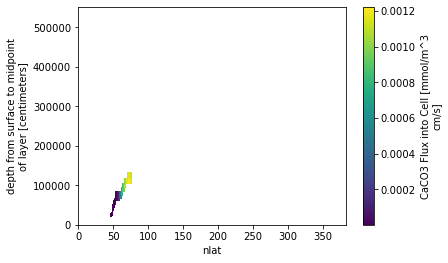

In [93]:
control_CaCO3flux.isel(nlon=120).plot()

In [94]:
SAZ_CaCO3_flux_control =  esmlab.weighted_mean(control_CaCO3flux, weights=area, dim=['nlat', 'nlon']).compute()
#dims: z_t,nlat,nlon
SAZ_CaCO3_flux_control = esmlab.weighted_mean(SAZ_CaCO3_flux_control, weights=dz, dim=['z_t']).compute()
#dims: none

In [96]:
#convert from mmol/m3 cm/s to gCaCO3/m2/yr
SAZ_CaCO3_flux_control = SAZ_CaCO3_flux_control.values * 0.01 * 86400 * 365 * 0.001 * 100.09
#SAZ_CaCO3_flux_control.attrs['units'] = 'gCaCO3 m-2 y-1'
SAZ_CaCO3_flux_control

In [98]:
SAZ_CaCO3_flux_2xGCB = SAZ_CaCO3_flux_control*2.

In [99]:
SAZ_CaCO3_flux_noGCB = SAZ_CaCO3_flux_control*0.

In [100]:
SAZ_CaCO3_flux_100mDLS = SAZ_ds.CaCO3_ALT_CO2_FLUX_IN_100mDLS.where(cesm_ann_ds.sigma>27.35).where(cesm_ann_ds.sigma<27.45)
SAZ_CaCO3_flux_100mDLS =  esmlab.weighted_mean(SAZ_CaCO3_flux_100mDLS, weights=area, dim=['nlat', 'nlon']).compute()
SAZ_CaCO3_flux_100mDLS = esmlab.weighted_mean(SAZ_CaCO3_flux_100mDLS, weights=dz, dim=['z_t']).compute()
#dims: none

In [101]:
#convert from mmol/m3 cm/s to gCaCO3/m2/yr
SAZ_CaCO3_flux_100mDLS = SAZ_CaCO3_flux_100mDLS * 0.01 * 86400 * 365 * 0.001 * 100.09
SAZ_CaCO3_flux_100mDLS.attrs['units'] = 'gCaCO3 m-2 y-1'

In [102]:
SAZ_CaCO3_flux_100mDLS

<xarray.DataArray ()>
array(3.24958586)
Attributes:
    long_name:     CaCO3 Flux into Cell, Alternative CO2
    units:         gCaCO3 m-2 y-1
    grid_loc:      3111
    cell_methods:  time: mean
    coordinates:   TLONG TLAT

In [103]:
SAZ_CaCO3_flux_1000mDLS = SAZ_ds.CaCO3_ALT_CO2_FLUX_IN_1000mDLS.where(cesm_ann_ds.sigma>27.35).where(cesm_ann_ds.sigma<27.45)
SAZ_CaCO3_flux_1000mDLS =  esmlab.weighted_mean(SAZ_CaCO3_flux_1000mDLS, weights=area, dim=['nlat', 'nlon']).compute()
SAZ_CaCO3_flux_1000mDLS = esmlab.weighted_mean(SAZ_CaCO3_flux_1000mDLS, weights=dz, dim=['z_t']).compute()
#dims: none

In [104]:
#convert from mmol/m3 cm/s to gCaCO3/m2/yr
SAZ_CaCO3_flux_1000mDLS = SAZ_CaCO3_flux_1000mDLS * 0.01 * 86400 * 365 * 0.001 * 100.09
SAZ_CaCO3_flux_1000mDLS.attrs['units'] = 'gCaCO3 m-2 y-1'

In [105]:
SAZ_CaCO3_flux_1000mDLS

<xarray.DataArray ()>
array(16.66025386)
Attributes:
    long_name:     CaCO3 Flux into Cell, Alternative CO2
    units:         gCaCO3 m-2 y-1
    grid_loc:      3111
    cell_methods:  time: mean
    coordinates:   TLAT TLONG

### CaCO3 fluxes in SAZ at sigma 27.4: diff from control

In [106]:
diff = SAZ_CaCO3_flux_2xGCB.values - SAZ_CaCO3_flux_control.values
diff

12.913241210291027

In [107]:
diff = SAZ_CaCO3_flux_noGCB.values - SAZ_CaCO3_flux_control.values
diff

-12.913241210291027

In [108]:
diff = SAZ_CaCO3_flux_100mDLS.values - SAZ_CaCO3_flux_control.values
diff

-9.663655349381049

In [109]:
diff = SAZ_CaCO3_flux_1000mDLS.values - SAZ_CaCO3_flux_control.values
diff

3.7470126526019634

In [110]:
SAZ_fluxes=[SAZ_CaCO3_flux_noGCB.values,SAZ_CaCO3_flux_100mDLS.values,SAZ_CaCO3_flux_control.values,SAZ_CaCO3_flux_1000mDLS.values,SAZ_CaCO3_flux_2xGCB.values]

In [111]:
SAZ_fluxes

[array(0.),
 array(3.24958586),
 array(12.91324121),
 array(16.66025386),
 array(25.82648242)]

In [112]:
#SAZ_ALKdiffs = [SAZ_noGCB_ALK_top_bottom_diff,SAZ_control_ALK_top_bottom_diff,SAZ_2xGCB_ALK_top_bottom_diff]

In [113]:
glb_ALKdiffs = [glb_noGCB_ALK_top_bottom_diff,glb_100mDLS_ALK_top_bottom_diff,glb_control_ALK_top_bottom_diff,glb_1000mDLS_ALK_top_bottom_diff,glb_2xGCB_ALK_top_bottom_diff]

### Make plot Alkalinity difference in SAZ (upper-lower cell) versus CaCO3 flux at sigma27.4

[Text(0, 0.5, 'Alkalinity (lower-upper; Pmol)'),
 Text(0.5, 0, 'CaCO$_3$ flux between 50°S and 30°S (g CaCO$_3$ m$^{-2}$ y$^{-1}$)')]

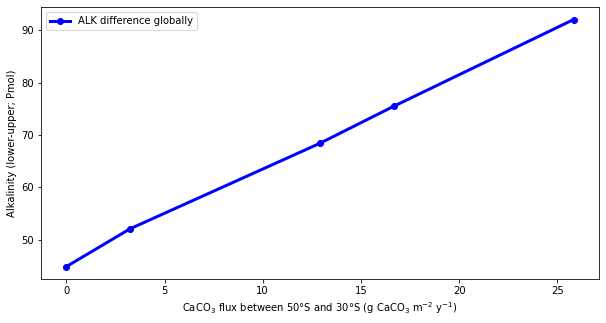

In [114]:
fig = plt.figure(figsize=(10,5))
#plt.suptitle('SAZ CaCO3 FLUX IN', fontsize=14)

ax = fig.add_subplot(1,1,1)
#ax.plot(SAZ_fluxes, SAZ_ALKdiffs, label='ALK difference in SAZ', linewidth=3,marker='o',color='red')
ax.plot(SAZ_fluxes,glb_ALKdiffs, label='ALK difference globally', linewidth=3,marker='o',color='blue')
ax.legend()

ax.set(ylabel='Alkalinity (lower-upper; Pmol)',xlabel='CaCO$_3$ flux between 50°S and 30°S (g CaCO$_3$ m$^{-2}$ y$^{-1}$)')

In [115]:
cesm_ann_ds

<xarray.Dataset>
Dimensions:               (nlat: 384, nlon: 320, z_t: 60, z_t_150m: 15)
Coordinates:
    TLAT                  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                 (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * z_t_150m              (z_t_150m) float32 500.0 1500.0 ... 13500.0 14500.0
  * z_t                   (z_t) float32 500.0 1500.0 ... 512502.8 537500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    KMT                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz                    (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    REGION_MASK           (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TAREA                 (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    PD                    (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>
    ALK                   (z_t, nlat, nlon) float32 ...
    ALK_ALT_CO2_noGCB     (z_t, nlat, nlon) float32 ...
    ALK_ALT_CO2_2xGCB     (z_t, nlat, nlon) float32 ...
    ALK_ALT_CO2_100mDLS   (z_t, nlat, nlon) float32 ...
    ALK_ALT_CO2_1000mDLS  (z_t, nlat, nlon) float32 ...
    sigma                 (z_t, nlat, nlon) float32 dask.array<chunksize=(60, 384, 320), meta=np.ndarray>

## Find latitudinal shift along 45S

#### Alk that's north of 45S for noGCB

In [116]:
N45S_ALK_noGCB = cesm_ann_ds.ALK_ALT_CO2_noGCB.where(lats>-45.)
#dims: z_t,nlat,nlon
N45S_ALK_noGCB = esmlab.weighted_sum(N45S_ALK_noGCB, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
N45S_ALK_noGCB = esmlab.weighted_sum(N45S_ALK_noGCB, weights=dz_m, dim=['z_t']).compute()
#dims: none
N45S_ALK_noGCB = N45S_ALK_noGCB.values * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
mean_N45S_ALK_noGCB = N45S_ALK_noGCB/volume_N45_tot * 1.e9
mean_N45S_ALK_noGCB

2429.532571893303

#### Alk that's south of 45S for noGCB

In [117]:
S45S_ALK_noGCB = cesm_ann_ds.ALK_ALT_CO2_noGCB.where(lats<=-45.)
#dims: z_t,nlat,nlon
S45S_ALK_noGCB = esmlab.weighted_sum(S45S_ALK_noGCB, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
S45S_ALK_noGCB = esmlab.weighted_sum(S45S_ALK_noGCB, weights=dz_m, dim=['z_t']).compute()
#dims: none
S45S_ALK_noGCB = S45S_ALK_noGCB.values * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
mean_S45S_ALK_noGCB =S45S_ALK_noGCB/volume_S45_tot * 1.e9
mean_S45S_ALK_noGCB

2396.171785406267

### Alk that's north of 45S for 100mDLS

In [118]:
N45S_ALK_100mDLS = cesm_ann_ds.ALK_ALT_CO2_100mDLS.where(lats>-45.)
#dims: z_t,nlat,nlon
N45S_ALK_100mDLS = esmlab.weighted_sum(N45S_ALK_100mDLS, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
N45S_ALK_100mDLS = esmlab.weighted_sum(N45S_ALK_100mDLS, weights=dz_m, dim=['z_t']).compute()
#dims: none
N45S_ALK_100mDLS = N45S_ALK_100mDLS.values * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
mean_N45S_ALK_100mDLS = N45S_ALK_100mDLS/volume_N45_tot * 1.e9
mean_N45S_ALK_100mDLS

2428.2324857598855

### Alk that's south of 45S for 100m DLS

In [119]:
S45S_ALK_100mDLS = cesm_ann_ds.ALK_ALT_CO2_100mDLS.where(lats<=-45.)
#dims: z_t,nlat,nlon
S45S_ALK_100mDLS = esmlab.weighted_sum(S45S_ALK_100mDLS, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
S45S_ALK_100mDLS = esmlab.weighted_sum(S45S_ALK_100mDLS, weights=dz_m, dim=['z_t']).compute()
#dims: none
S45S_ALK_100mDLS = S45S_ALK_100mDLS.values * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
mean_S45S_ALK_100mDLS =S45S_ALK_100mDLS/volume_S45_tot * 1.e9
mean_S45S_ALK_100mDLS

2397.16408864796

#### Alk that's north of 45S for control

In [120]:
N45S_ALK_control = cesm_ann_ds.ALK.where(lats>-45.)
#dims: z_t,nlat,nlon
N45S_ALK_control = esmlab.weighted_sum(N45S_ALK_control, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
N45S_ALK_control = esmlab.weighted_sum(N45S_ALK_control, weights=dz_m, dim=['z_t']).compute()
#dims: none
N45S_ALK_control = N45S_ALK_control.values * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
mean_N45S_ALK_control = N45S_ALK_control/volume_N45_tot * 1.e9
mean_N45S_ALK_control

2425.9914139401803

#### Alk that's south of 45S for control

In [121]:
S45S_ALK_control = cesm_ann_ds.ALK.where(lats<=-45.)
#dims: z_t,nlat,nlon
S45S_ALK_control = esmlab.weighted_sum(S45S_ALK_control, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
S45S_ALK_control = esmlab.weighted_sum(S45S_ALK_control, weights=dz_m, dim=['z_t']).compute()
#dims: none
S45S_ALK_control = S45S_ALK_control.values * 0.001 * 1e-15 #convert from mmol Alk to Tmol Alk
mean_S45S_ALK_control = S45S_ALK_control/volume_S45_tot * 1.e9
mean_S45S_ALK_control

2400.4032746871417

### Alk that's north of 45S for 1000mDLS

In [122]:
N45S_ALK_1000mDLS = cesm_ann_ds.ALK_ALT_CO2_1000mDLS.where(lats>-45.)
#dims: z_t,nlat,nlon
N45S_ALK_1000mDLS = esmlab.weighted_sum(N45S_ALK_1000mDLS, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
N45S_ALK_1000mDLS = esmlab.weighted_sum(N45S_ALK_1000mDLS, weights=dz_m, dim=['z_t']).compute()
#dims: none
N45S_ALK_1000mDLS = N45S_ALK_1000mDLS.values * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
mean_N45S_ALK_1000mDLS = N45S_ALK_1000mDLS/volume_N45_tot * 1.e9
mean_N45S_ALK_1000mDLS

2424.924073414527

### Alk that's south of th45S for 1000mDLS

In [123]:
S45S_ALK_1000mDLS = cesm_ann_ds.ALK_ALT_CO2_1000mDLS.where(lats<=-45.)
#dims: z_t,nlat,nlon
S45S_ALK_1000mDLS = esmlab.weighted_sum(S45S_ALK_1000mDLS, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
S45S_ALK_1000mDLS = esmlab.weighted_sum(S45S_ALK_1000mDLS, weights=dz_m, dim=['z_t']).compute()
#dims: none
S45S_ALK_1000mDLS = S45S_ALK_1000mDLS.values * 0.001 * 1e-15 #convert from mmol Alk to Pmol Alk
mean_S45S_ALK_1000mDLS =S45S_ALK_1000mDLS/volume_S45_tot * 1.e9
mean_S45S_ALK_1000mDLS

2400.481450484584

#### Alk that's north of 45S for 2xGCB

In [124]:
N45S_ALK_2xGCB = cesm_ann_ds.ALK_ALT_CO2_2xGCB.where(lats>-45.)
#dims: z_t,nlat,nlon
N45S_ALK_2xGCB = esmlab.weighted_sum(N45S_ALK_2xGCB, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
N45S_ALK_2xGCB = esmlab.weighted_sum(N45S_ALK_2xGCB, weights=dz_m, dim=['z_t']).compute()
#dims: none
N45S_ALK_2xGCB = N45S_ALK_2xGCB.values * 0.001 * 1e-15 #convert from mmol Alk to Tmol Alk
mean_N45S_ALK_2xGCB = N45S_ALK_2xGCB/volume_N45_tot * 1.e9
mean_N45S_ALK_2xGCB

2422.443672562693

#### Alk that's south of 45S for 2xGCB

In [125]:
S45S_ALK_2xGCB = cesm_ann_ds.ALK_ALT_CO2_2xGCB.where(lats<=-45.)
#dims: z_t,nlat,nlon
S45S_ALK_2xGCB = esmlab.weighted_sum(S45S_ALK_2xGCB, weights=area_m, dim=['nlat', 'nlon']).compute()
#dims: z_t
S45S_ALK_2xGCB = esmlab.weighted_sum(S45S_ALK_2xGCB, weights=dz_m, dim=['z_t']).compute()
#dims: none
S45S_ALK_2xGCB = S45S_ALK_2xGCB.values * 0.001 * 1e-15 #convert from mmol Alk to Tmol Alk
mean_S45S_ALK_2xGCB = S45S_ALK_2xGCB/volume_S45_tot * 1.e9
mean_S45S_ALK_2xGCB

2404.6219062362297

### Find N/S differences

In [126]:
noGCB_ALK_NS_diff = mean_N45S_ALK_noGCB - mean_S45S_ALK_noGCB
noGCB_ALK_NS_diff

33.360786487035966

In [127]:
control_ALK_NS_diff = mean_N45S_ALK_control - mean_S45S_ALK_control
control_ALK_NS_diff

25.588139253038662

In [128]:
GCB2x_ALK_NS_diff = mean_N45S_ALK_2xGCB - mean_S45S_ALK_2xGCB
GCB2x_ALK_NS_diff

17.82176632646315

### Alk diffs of diffs from N/S shift

In [129]:
noGCB_ALK_NS_diff - control_ALK_NS_diff

7.772647233997304

In [130]:
GCB2x_ALK_NS_diff - control_ALK_NS_diff

-7.766372926575514